# DSViz: IDF Ridership Analysis

Luca Uckermann [](https://orcid.org/0009-0005-2957-6331) (University of Applied Sciences (TH Köln))  
Nikethan (Gustave Eiffel University)  
Adel (Gustave Eiffel University)  
Cong Son (Cong Son’s University)  
Francky (Francky’s University)  
December 2, 2024

This project analyzes public transport ridership trends in Île-de-France from 2018 to 2023. Using a Shiny-based interactive application, it explores temporal and spatial ridership patterns, predicts future trends, and evaluates the impact of holidays and school vacations.

# Introduction

## Background

The objective of this project is to analyze and visualize public transport ridership data in the Île-de-France (IDF) region from 2018 to 2023. By examining the temporal and spatial patterns of ridership, the aim is to provide insights into the use of public transport services, identify trends, and forecast future ridership patterns.

Île-de-France Mobilités (IdFM) (formerly STIF) \[@idf2024\] is the public transport authority that coordinates and organizes public transport in the IDF region. Understanding ridership trends is essential for planning and optimizing public transport services to meet the needs of the population. IdFM collects ridership data, including daily validations for public transport, hourly percentage distribution of ridership by day type, and mapping information for stations. All this data is publicly available on their “Plateforme Régionale d’Information pour la Mobilité” (PRIM) platform \[@idf_prim2024\].

A beneficial side-effect of this project is to get to know the R programming language and its capabilities for data analysis and visualization. Furthermore, popular packages for data manipulation, visualization and interactive web applications will be used in this project.

## Objectives

The project was guided by the following objectives

-   Collect and clean ridership data from the IDF region.
-   Investigate temporal and spatial trends in ridership patterns.
-   Compare ridership during holidays and school vacations to normal periods.
-   Develop and deploy an interactive web dashboard to visualize ridership data.
-   Apply statistical methods to validate findings and derive insights.

# Data Collection and Preparation

## Data Collection

The data used in this project are publicly available on the PRIM platform of the IdFM. All datasets have been downloaded and pushed to the project’s GitHub repository \[@dsviz_project_github2024\] for further data cleaning and analysis. The datasets used in this project include:

### Number of validations per day (nb_fer):

| **COLUMN** | **DEFINITION** |
|-------------------|-----------------------------------------------------|
| **JOUR** | Operational day (from 04:00 AM to 03:59 AM the next day) |
| **COD_STIF_TRNS** | Transport operator code |
| **COD_STIF_RES** | Transport network code |
| **COD_STIF_ARRET** | Stop/station code |
| **LIBELLE_ARRET** | Name of the stop/station |
| **ID_REFA_LDA** | Identifier of the stop in the STIF reference system |
| **CATEGORIE_TITRE** | Type of transportation ticket |
| **NB_VALD** | Number of validations (entries into the network) |

### Time profiles by type of day (profil_fer)

#### Profile Data:

| **COLUMN** | **DEFINITION** |
|-----------|-------------------------------------------------------------|
| **COD_STIF_TRNS** | Transport operator code |
| **COD_STIF_RES** | Transport network code |
| **COD_STIF_ARRET** | Stop/station code |
| **LIBELLE_ARRET** | Name of the stop/station |
| **ID_REFA_LDA** | Identifier of the stop in the STIF reference system |
| **CAT_JOUR** | Day category (see @tbl-day_categories) |
| **TRNC_HORR_60** | One-hour time slot |
| **POURC_VALIDATIONS** | For a station *s*: Ratio of the validations at station *s* during a time slot `TRNC_HORR_60`, to the `NB_VALD` for the day at station *s* |

#### Day Categories:

| **DAY CATEGORY** | **DEFINITION**                            |
|------------------|-------------------------------------------|
| **DIJFP**        | Sundays, public holidays, and bridge days |
| **JOHV**         | Weekdays outside school holidays          |
| **JOVS**         | Weekdays during school holidays           |
| **SAHV**         | Saturdays outside school holidays         |
| **SAVS**         | Saturdays during school holidays          |

### Zones and spatial data (zones & ref_zda):

#### Zones Data:

| **COLUMN**          | **DEFINITION**                                     |
|---------------------|----------------------------------------------------|
| **ZdAId**           | Unique identifier for the zone                     |
| **ZdAVersion**      | Version information for the zone data              |
| **ZdACreated**      | Date and time when the entry was created           |
| **ZdAChanged**      | Date and time when the entry was last modified     |
| **ZdAName**         | Zone name                                          |
| **ZdAXEpsg2154**    | X-coordinate of the zone in EPSG:2154 projection   |
| **ZdAYEpsg2154**    | Y-coordinate of the zone in EPSG:2154 projection   |
| **ZdCId**           | Identifier for the associated geographical cluster |
| **ZdAPostalRegion** | Postal region or code where the zone is located    |
| **ZdATown**         | Name of the town or city where the zone is located |
| **ZdAType**         | Type of stop/station                               |

#### Spatial Data:

| **COLUMN** | **DEFINITION** |
|---------------|---------------------------------------------------------|
| **NOM** | Name of the stop or station |
| **ID_REFA** | Unique identifier for the reference area associated with the stop/station |
| **UNITE_ORGA** | Organizational unit associated with the stop/station |
| **COMMUNE** | Code for the commune (municipality) where the stop/station is located |
| **TYPE_ARRET** | Type of stop/station |
| **IDREFA_IDA** | Identifier for the specific stop/station within the reference framework |
| **NOM_IDA** | Full name or label for the stop/station |
| **TYPE_OBJET** | Type of object or feature in the dataset |
| **GEOMETRY** | Geographic data for the stop/station |

## **Data Preparation**

The reproducible data cleaning process is performed using the R script (`cleaning.R`). The script involves several sequential steps to prepare the raw ridership data for analysis. Below are the key steps and the corresponding actions taken:

### 1. Data Loading

The **Data Loading** process is the first step in preparing the ridership data for analysis. This code dynamically constructs file paths for the ridership (`NB_FER`) and profile (`PROFIL_FER`) datasets, providing flexibility in handling data for different years and formats.

In general, the datasets for each year are split into two semesters (`S1` and `S2`), with corresponding files for the number of validations (`NB_FER`) and hourly profiles (`PROFIL_FER`). To keep the report concise, the following cleaning process is demonstrated only for the first semester data (`S1`), but the same steps are applied to the second semester data (`S2`).

``` r
nb_s1 <- sprintf("data/data-rf-%s/%s_S1_NB_FER.txt", year, year)
profil_s1 <- sprintf("data/data-rf-%s/%s_S1_PROFIL_FER.txt", year, year)

delim <- if (year == "2023") ";" else "\t"
nb_s1_df <- read_delim(nb_s1, delim = delim, col_types = cols(.default = col_character()), guess_max = 10000, locale = locale(decimal_mark = ","))
profil_s1_df <- read_delim(profil_s1, delim = delim, col_types = cols(.default = col_character()), guess_max = 10000, locale = locale(decimal_mark = ","))
```

Here the `sprintf()` function is used to construct file paths for the ridership and profile records based on the selected year. The `read_delim()` function from the `readr` package \[@readr2024\] is then used to read the data from the text files.

Only for the year 2023, the delimiter is set to `;` instead of the default `tab` delimiter due to differences in data format. The `locale` parameter is used to set the decimal separator to `,` for correct numeric parsing.

This **Data Loading** step ensures that the raw data is successfully loaded and ready for preprocessing and analysis. It provides a solid foundation for subsequent data manipulation and cleaning steps.

### 2. Data Manipulation

The **Data Manipulation** step ensures that the loaded data is consistent, standardized, and ready for further processing. This includes renaming columns for clarity, converting date and numeric formats, and applying transformations to align the data structure.

``` r
colnames(nb_s1_df) <- tolower(colnames(nb_s1_df))
colnames(profil_s1_df) <- tolower(colnames(profil_s1_df))

nb_s1_df <- nb_s1_df |>
    rename_with(~ gsub("^lda$", "id_refa_lda", .x), everything())
profil_s1_df <- profil_s1_df |>
    rename_with(~ gsub("^lda$", "id_refa_lda", .x), everything())
```

For consistency and readability, all column names are converted to lowercase using `tolower()`. In addition, all occurrences of the column name `lda` are renamed to `id_refa_lda` to ensure consistent alignment across datasets.

``` r
if (year == "2023") {
    nb_s1_df$jour <- ymd(nb_s1_df$jour)
} else {
    nb_s1_df$jour <- dmy(nb_s1_df$jour)
}
```

The date column (`jour`) is converted to a proper date type for consistency in downstream analysis. Depending on the year of the dataset, either `ymd()` (year-month-day) or `dmy()` (day-month-year) from the `lubridate` package \[@lubridate2011\] is used to parse the date correctly.

``` r
nb_s1_df <- nb_s1_df |>
    mutate(nb_vald = as.numeric(nb_vald))
profil_s1_df <- profil_s1_df |>
    mutate(
        pourc_validations = as.numeric(gsub(",", ".", pourc_validations)),
        jour = year
    )
```

The numeric columns `nb_vald` and `pourc_validations` are converted to numeric formats. The `pourc_validations` column requires an additional transformation to replace commas with dots for correct parsing. The `jour` column in the profile data is assigned the value of the year to allow identification of the origin of the data even after the following data aggregation.

### 3. Data Cleaning

The **Data Cleaning** step ensures that the datasets are free of missing values and inconsistencies. This process involves removing any rows with missing values and consolidating the data to a structured format for analysis.

``` r
nb_s1_df <- na.omit(nb_s1_df)
profil_s1_df <- na.omit(profil_s1_df)
```

The `na.omit()` function is used to remove rows with missing values from the datasets. Although debugging revealed that there are no missing values in the current datasets (see @tbl-data_cleaning_summary), this function is retained to handle potential missing values in future datasets.

``` r
nb_s1_df <- nb_s1_df |>
    select(jour, id_refa_lda, libelle_arret, nb_vald) |>
    mutate(libelle_arret = toupper(str_trim(libelle_arret))) |>
    group_by(jour, id_refa_lda, libelle_arret) |>
    summarise(nb_vald = sum(nb_vald, na.rm = TRUE), .groups = "drop")

profil_s1_df <- profil_s1_df |>
    select(jour, id_refa_lda, libelle_arret, cat_jour, trnc_horr_60, pourc_validations) |>
    mutate(libelle_arret = toupper(str_trim(libelle_arret))) |>
    group_by(jour, id_refa_lda, libelle_arret, cat_jour, trnc_horr_60) |>
    summarise(pourc_validations = mean(pourc_validations, na.rm = TRUE), .groups = "drop")
```

For consistency, the column `libelle_arret` (station name) is cleaned by converting all station names to uppercase with `toupper()` and removing leading and trailing spaces with `str_trim()` from the `stringr` package \[@stringr2023\]. The data is then grouped by key identifiers and relevant attributes to consolidate the information. For `nb_s1_df` the records are grouped by `jour`, `id_refa_lda` and `libelle_arret` and the total number of validations (`nb_vald`) is calculated for each group. Similarly, for `profil_s1_df`, records are grouped by `jour`, `id_refa_lda`, `libelle_arret`, `cat_jour` (day category), and `trnc_horr_60` (hour interval), and the average percentage of validations (`pourc_validations`) is calculated for each group. This reduces the data to a minimal and structured format for further analysis.

### 4. Outlier Detection

The **Outlier Detection** step ensures that extreme values in the dataset, which may skew the analysis or represent data entry errors, are systematically identified and removed. This is achieved using an interquartile range (IQR)-based approach applied to all numeric columns in the dataset.

``` r
remove_outliers <- function(data) {
    for (col in colnames(data)) {
        if (is.numeric(data[[col]])) {
            q1 <- quantile(data[[col]], 0.25, na.rm = TRUE)
            q3 <- quantile(data[[col]], 0.75, na.rm = TRUE)
            iqr <- q3 - q1
            lower_bound <- q1 - 1.5 * iqr
            upper_bound <- q3 + 1.5 * iqr

            # Filter outliers
            data <- data[data[[col]] >= lower_bound & data[[col]] <= upper_bound, ]
        }
    }
    return(data)
}
```

The `remove_outliers()` function iterates through each numeric column in the dataset and calculates the first quartile (Q1) and the third quartile (Q3) for that column. The interquartile range (IQR) is then calculated as the difference between Q3 and Q1. The IQR is used to define lower and upper bounds to identify outliers:

-   **Lower Bound**: `Q1 - 1.5 * IQR`
-   **Upper Bound**: `Q3 + 1.5 * IQR`

Rows with numeric values outside these bounds are filtered out, effectively removing outliers (see @tbl-data_cleaning_summary).

### 5. Spatial Data Integration

The **Spatial Data Integration** step combines the zone data with geospatial data to provide insight into station-level patterns and to enable spatial visualizations. This process involves loading, transforming, and merging geospatial information with related zone data.

``` r
read_spatial_data <- function() {
    zones <- read_delim("data/zones.csv", delim = ";")
    zones_spatial <- st_read("data/REF_ZdA/PL_ZDL_R_14_11_2024.shp", crs = 2154)

    names(zones) <- tolower(names(zones))

    zones_spatial <- zones_spatial |>
        st_make_valid() |>
        st_transform(4326) |>
        mutate(idrefa_lda = as.character(idrefa_lda)) |>
        full_join(zones, by = c("id_refa" = "zdaid"))

    centroids <- st_centroid(zones_spatial)
    zones_spatial$longitude <- st_coordinates(centroids)[, 1]
    zones_spatial$latitude <- st_coordinates(centroids)[, 2]

    zones_spatial <- zones_spatial |>
        st_drop_geometry() |>
        rename_with(~ gsub("^idrefa_lda$", "id_refa_lda", .x), everything()) |>
        mutate(nom_lda = toupper(str_trim(nom_lda))) |>
        select(id_refa_lda, nom_lda, longitude, latitude)

    return(zones_spatial)
}
```

Spatial data integration begins by loading two data sources:

1.  **Station Data** (`zones.csv`): A CSV file containing station information.
2.  **Geospatial Data** (`PL_ZDL_R_14_11_2024.shp`): A shapefile representing the geographic boundaries of the stations. This data is read using the `st_read()` function from the `sf` package \[@sf2018;@sf2023\], with the coordinate reference system (CRS) specified as EPSG:2154 \[@epsg_lambert2024\].

Several transformations and merges are performed to ensure compatibility of the spatial data. First, the `st_make_valid()` function is applied to the shapefile data to ensure that all geometries are valid before further processing. The coordinate reference system (CRS) is then transformed to WGS84 (EPSG:4326) \[@epsg_world2024\], which is widely used for web-based visualization tools such as `leaflet` \[@leaflet2024\]. After these transformations, the shapefile data are merged with the station data (`zones`) using the `full_join()` function. The merge is based on matching the `id_refa` column from the shapefile with the `zdaid` column in the CSV file.

To represent stations as points, the centroids of the polygons in the shapefile are calculated using the `st_centroid()` function. The latitude and longitude of each centroid is extracted and added as a new column to the spatial data, allowing for accurate point-based visualizations.

The processed spatial data undergoes additional cleaning to make it more streamlined for analysis and visualization. Geometries are dropped using the `st_drop_geometry()` function as they are no longer needed for point-based visualizations. Column names are standardized and station names (`nom_lda`) are converted to uppercase and truncated to ensure consistency with the `nb_vald` and `profil` datasets. Finally, the dataset is filtered to keep only the relevant columns: `id_refa_lda`, `nom_lda`, `longitude` and `latitude`.

The resulting dataset includes station identifiers, names, and geographic coordinates (latitude and longitude). This integrated spatial data is essential for mapping and visualizing ridership patterns at the station level, providing the basis for meaningful geospatial analysis. It also removes unnecessary geometries to reduce the size of the dataset and improve processing efficiency, especially when developing and deploying the web application later (see @sec-dashboard-development-deployment).

### 6. Data Export

The **Data Export** step ensures that the cleaned and processed datasets are saved in an efficient format for future use. The ridership data (`nb_vald` and `profil`) and the spatial data (`zones_spatial`) are saved as RDS files \[@rds2024\] in the `data/cleaned_data/` directory. These RDS files are compact, fast to read, and preserve the structure of R objects, making them ideal for downstream analysis.

``` r
saveRDS(combined_data$nb_vald, "data/cleaned_data/combined_nb_vald.rds")
saveRDS(combined_data$profil, "data/cleaned_data/combined_profil.rds")

saveRDS(spatial_data, "data/cleaned_data/zones_spatial.rds")
```

### Script Workflow

The entire data preparation process is encapsulated in the `main()` function, which ensures that all steps are performed sequentially. The workflow consists of the following steps:

1.  **Ridership Data Preparation**: The 2018-2023 data is cleaned and aggregated using the `read_clean_data()` function.
2.  **Spatial Data Integration**: Spatial data is cleaned, transformed and merged using the `read_spatial_data()` function.
3.  **Data Export**: The cleaned ridership and spatial datasets are saved as RDS files (`export_data()` and `export_spatial_data()` functions).

``` r
main <- function(years) {
    export_data(read_clean_data(years))
    export_spatial_data(read_spatial_data())
}
main(c("2018", "2019", "2020", "2021", "2022", "2023"))
```

The `main()` function is called with a list of years to process, ensuring that the data cleaning and export steps are applied consistently to all selected years. This approach streamlines the data preparation process, making it efficient, reproducible, and scalable for future analyses (e.g., adding new years or updating existing data).

### Tools and Libraries

The data cleaning process relies on several R packages that provide powerful tools for data manipulation, spatial processing, and text formatting. To summarize, the key packages used in the data preparation workflow include:

-   `dplyr`: For efficient data manipulation, filtering, and summarization. \[@dplyr2023\]
-   `readr`: For reading delimited files with flexible parsing options. \[@readr2024\]
-   `sf`: For managing and processing spatial data, including transformations and centroid calculations. \[@sf2018;@sf2023\]
-   `lubridate`: For seamless handling of date formats and conversions. \[@lubridate2011\]
-   `stringr`: For string manipulation, such as trimming and formatting text. \[@stringr2023\]

### Key Outputs

The data cleanup and processing workflow produces the following key outputs:

-   `combined_nb_vald.rds`: A cleaned dataset containing daily validation counts for all stations.
-   `combined_profil.rds`: A combined dataset with hourly profiles showing validation percentages by day type and hourly intervals.
-   `zones_spatial.rds`: A “spatial” dataset containing station names, unique IDs, and their geographic coordinates (latitude and longitude).

The cleaning process ensures that the data is accurate, consistent, and properly formatted for downstream analysis and visualization. These outputs provide a robust foundation for exploring ridership trends, performing geospatial analysis, and building interactive visualizations.

# Exploratory Data Analysis in Shiny

## Overview

The Exploratory Data Analysis (EDA) is integrated directly into the Shiny application \[@shiny2024\] and provides an interactive platform for analyzing ridership patterns in the IDF region. The application includes several tabs that provide dynamic visualizations and analysis tools. The main objectives of the EDA through the app are:

1.  Analyze trends over time (yearly, monthly and weekly).
2.  Allow comparisons between different time periods.
3.  Examine ridership patterns and spatial distribution at the station level.
4.  Visualize forecasting results for future ridership.

## Key EDA Features and Functionality

This subsection discusses the code and approach used to implement the main features and functionality of the dynamic Shiny application. The graphical output and analysis for certain static scenarios is covered in the @sec-norms-statistical-methods section.

### Total Validations

The **Total Validations** tab in the Shiny application provides users with an overview of ridership trends by summarizing the total number of validations (entries into the network) on a yearly and monthly level. This functionality uses R’s `ggplot2` \[@ggplot2016\] library to create visually appealing graphs that highlight the aggregated validation counts.

The first plot, `Yearly Total Validations`, groups the data by year and calculates the total number of validations for each year. The `mutate()` function extracts the year from the date column (`jour`), and the `group_by()` function ensures that the calculations are performed for each distinct year. The `summarize()` function aggregates the data by summing the number of validations (`nb_vald`). The results are visualized as a bar chart, where the x-axis represents the years and the y-axis shows the total number of validations. The minimal theme (`theme_minimal()`) ensures that the chart remains clear and professional.

``` r
output$yearlySumPlot <- renderPlot({
    yearly_sum <- combined_nb_vald |>
        mutate(year = year(jour)) |>
        group_by(year) |>
        summarize(total_validations = sum(nb_vald, na.rm = TRUE))

    ggplot(yearly_sum, aes(x = year, y = total_validations)) +
        geom_col() +
        labs(title = "Total Validations (Yearly)", x = "Year", y = "Total Validations") +
        theme_minimal()
})
```

Similarly, the second plot, `Monthly Total Validations`, takes a more granular approach by grouping the data by month. The `floor_date()` function is used to extract and group the data by the start of each month, allowing for monthly aggregation. Again, the `summarize()` function calculates the total number of validations for each month and displays the results as a bar chart. To improve readability, the x-axis labels (representing the months) are rotated slightly (`element_text(angle = 45)`) for better alignment and visibility.

``` r
output$monthlySumPlot <- renderPlot({
    monthly_sum <- combined_nb_vald |>
        mutate(month = floor_date(jour, "month")) |>
        group_by(month) |>
        summarize(total_validations = sum(nb_vald, na.rm = TRUE))

    ggplot(monthly_sum, aes(x = month, y = total_validations)) +
        geom_col() +
        labs(title = "Total Validations (Monthly)", x = "Month", y = "Total Validations") +
        theme_minimal() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))
})
```

These visualizations provide an intuitive way to explore overall traffic trends over time, identifying high and low traffic periods in both annual and monthly dimensions.

### Trends

The **Trends** tab in the Shiny app allows users to explore ridership patterns across multiple time dimensions, including yearly, monthly, and weekly trends. This functionality helps identify long-term changes, seasonal variations, and weekday usage patterns, all visualized with dynamic and interactive charts.

The `Yearly Trend` plot calculates the average number of validations (`avg_vald`) for each year. The `mutate()` function is used to extract the year from the date column (`jour`), and the data is grouped by year using `group_by()`. The average validations are calculated using `summarize()`, and the results are plotted as a line chart with each year on the x-axis and the average validations on the y-axis. Points are added to highlight the yearly averages, and the minimalist theme provides clarity.

``` r
output$yearlyTrendPlot <- renderPlot({
    yearly_trend <- combined_nb_vald |>
        mutate(year = year(jour)) |>
        group_by(year) |>
        summarize(avg_vald = mean(nb_vald, na.rm = TRUE))

    ggplot(yearly_trend, aes(x = year, y = avg_vald)) +
        geom_line(size = 1) +
        geom_point(size = 3) +
        labs(title = "Yearly Trend", x = "Year", y = "Average Validations") +
        theme_minimal()
})
```

The `Monthly Trend` plot provides a more granular view by grouping the data by month. The `floor_date()` function is used to group validations by the start of each month, and `summarize()` is used to calculate the average validations for each month. The results are plotted as a line graph, with markers added for clarity.

``` r
output$monthlyTrendPlot <- renderPlot({
    monthly_trend <- combined_nb_vald |>
        mutate(month = floor_date(jour, "month")) |>
        group_by(month) |>
        summarize(mean_vald = mean(nb_vald, na.rm = TRUE))

    ggplot(monthly_trend, aes(x = month, y = mean_vald)) +
        geom_line(size = 1) +
        geom_point(size = 3) +
        labs(title = "Monthly Trend", x = "Month", y = "Average Validations") +
        theme_minimal()
})
```

The `Weekday Trend` plot focuses on daily patterns by grouping data by day of the week. The `wday()` function assigns a weekday label (e.g., Monday, Tuesday), and `summarize()` calculates the average number of validations for each weekday. A bar graph is then used to visualize the average validations for each day, highlighting differences between, for example, weekdays and weekends.

``` r
output$weekdayTrendPlot <- renderPlot({
    weekday_trend <- combined_nb_vald |>
        mutate(weekday = wday(jour, label = TRUE, week_start = 1)) |>
        group_by(weekday) |>
        summarize(mean_vald = mean(nb_vald, na.rm = TRUE))

    ggplot(weekday_trend, aes(x = weekday, y = mean_vald)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(title = "Weekday Trend", x = "Weekday", y = "Average Validations") +
        theme_minimal()
})
```

These visualizations provide a detailed examination of ridership patterns, making it easy to identify trends such as seasonal ridership spikes, long-term annual growth or decline, and differences between weekday and weekend ridership.

### Comparison

The **Comparison** tab in the Shiny app helps analyze ridership patterns over two user-defined time periods. This functionality provides detailed comparisons of daily trends, weekday patterns, and total validations to help identify changes or anomalies between the selected time periods.

The `Daily Comparison` graph shows the average number of validations per day for each time period. The data is grouped by relative day (a numerical index representing days within the selected time period) and Period (`Period 1` or `Period 2`). The display uses a line chart with different colors for each period, allowing the comparison of daily trends between the two periods.

``` r
output$comparisonDaysPlot <- renderPlot({
    data <- comparison_data()

    daily_trend <- data |>
        group_by(relative_day, period, original_date = jour) |>
        summarize(avg_vald = mean(nb_vald, na.rm = TRUE), .groups = "drop")

    ggplot(daily_trend, aes(x = relative_day, y = avg_vald, color = period, group = period)) +
        geom_line(size = 1) +
        geom_point(size = 3) +
        labs(
            title = paste("Comparison of Two Periods (", input$period_days, " Days)", sep = ""),
            x = "Time",
            y = "Average Validations"
        ) +
        theme_minimal()
})
```

The `Weekday Comparison` graph highlights the differences in ridership patterns for each day of the week between the two selected periods. The data is grouped by weekday (e.g., Monday, Tuesday) and time period, and averages are calculated. A bar graph is used to display the results, with different colors representing each period.

``` r
output$comparisonWeekdayPlot <- renderPlot({
    data <- comparison_data()

    weekday_trend <- data |>
        group_by(weekday = wday(jour, label = TRUE, week_start = 1), period) |>
        summarize(avg_vald = mean(nb_vald, na.rm = TRUE), .groups = "drop")

    ggplot(weekday_trend, aes(x = weekday, y = avg_vald, fill = period)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(
            title = paste("Weekday Comparison of Two Periods (", input$period_days, " Days)", sep = ""),
            x = "Weekday",
            y = "Average Validations"
        ) +
        theme_minimal()
})
```

The `Daily Total Validations` graph compares the cumulative number of validations for each day of the selected time periods. The data is grouped by relative day and period, and the total number of validations is calculated. A line chart is used, similar to the `Average Validations` plot, but focusing on the total number of validations.

``` r
output$comparisonDaysPlotTotal <- renderPlot({
    data <- comparison_data()

    daily_trend <- data |>
        group_by(relative_day, period, original_date = jour) |>
        summarize(total_validations = sum(nb_vald, na.rm = TRUE), .groups = "drop")

    ggplot(daily_trend, aes(x = relative_day, y = total_validations, color = period, group = period)) +
        geom_line(size = 1) +
        geom_point(size = 3) +
        labs(
            title = paste("Comparison of Two Periods (", input$period_days, " Days)", sep = ""),
            x = "Time",
            y = "Total Validations"
        ) +
        theme_minimal()
})
```

The `Weekday Total Validations` graph provides a similar comparison to the `Weekday Trends` graph, but focuses on total validations rather than averages. This graph provides insight into the cumulative ridership patterns for each day of the week.

``` r
output$comparisonWeekdayPlotTotal <- renderPlot({
    data <- comparison_data()

    weekday_trend <- data |>
        group_by(weekday = wday(jour, label = TRUE, week_start = 1), period) |>
        summarize(total_validations = sum(nb_vald, na.rm = TRUE), .groups = "drop")

    ggplot(weekday_trend, aes(x = weekday, y = total_validations, fill = period)) +
        geom_bar(stat = "identity", position = "dodge") +
        labs(
            title = paste("Weekday Comparison of Two Periods (", input$period_days, " Days)", sep = ""),
            x = "Weekday",
            y = "Total Validations"
        ) +
        theme_minimal()
})
```

The **Comparison** tab provides a powerful tool for evaluating how ridership patterns vary between two selected time periods, such as comparing pre- and post-pandemic trends. By analyzing both average and total validations for daily and weekday patterns, one can understand temporal shifts in ridership. These visualizations are particularly valuable for identifying the impact of external factors, such as unforeseen events or policy changes on public transport ridership.

### Stations Map

The **Stations Map** tab in the Shiny app allows the user to explore the spatial distribution of ridership across stations. This tab integrates ridership data with geospatial data to create an interactive map using the `leaflet` package. The map provides a visual representation of station locations, ridership, and additional statistics to analyze ridership trends at the station level.

The main feature of this tab is an interactive map that displays the geographic locations of stations. Each station is represented by a marker, with the size of the marker scaled according to the total number of validations (`total_validations`) for the selected year. The markers are color-coded to indicate whether they match the user-selected station, with green representing the selected station and red for others.

``` r
output$stationMap <- renderLeaflet({
    selected_station <- input$station

    selected_station_ids <- combined_nb_vald |>
        filter(libelle_arret == selected_station) |>
        distinct(id_refa_lda) |>
        pull(id_refa_lda)

    yearly_validations <- combined_nb_vald |>
        group_by(id_refa_lda) |>
        summarise(total_validations = sum(nb_vald, na.rm = TRUE), .groups = "drop")

    filtered_zones_spatial <- zones_spatial |>
        filter(id_refa_lda %in% filtered_stations()$id_refa_lda) |>
        left_join(yearly_validations, by = c("id_refa_lda" = "id_refa_lda")) |>
        mutate(
            scaled_size = ifelse(is.na(total_validations), 5, total_validations / max(total_validations, na.rm = TRUE) * 20)
        )

    leaflet(filtered_zones_spatial) |>
        addTiles() |>
        addCircleMarkers(
            lng = ~longitude,
            lat = ~latitude,
            popup = ~ paste("Station:", nom_lda),
            layerId = ~id_refa_lda,
            color = ~ ifelse(id_refa_lda %in% selected_station_ids, "green", "red"),
            radius = ~scaled_size
        )
})
```

In addition to the interactive map, this tab provides detailed statistics for the selected station. These statistics include the total number of validations for the selected year, the average daily validations, and the minimum and maximum daily validations.

``` r
output$stationStats <- renderPrint({
    selected_station <- input$station
    if (is.null(selected_station) || selected_station == "") {
        return("No station selected.")
    }

    selected_station_ids <- combined_nb_vald |>
        filter(libelle_arret == selected_station) |>
        distinct(id_refa_lda) |>
        pull(id_refa_lda)

    if (length(selected_station_ids) == 0) {
        return(paste("No data found for station:", selected_station))
    }

    station_data <- combined_nb_vald |>
        filter(id_refa_lda %in% selected_station_ids)

    total_validations_summary <- station_data |>
        filter(year(jour) == as.numeric(input$year)) |>
        summarise(
            TotalValidations = sum(nb_vald, na.rm = TRUE),
            AvgDailyValidations = mean(nb_vald, na.rm = TRUE),
            MinDailyValidations = min(nb_vald, na.rm = TRUE),
            MaxDailyValidations = max(nb_vald, na.rm = TRUE)
        )

    yearly_validations_summary <- station_data |>
        mutate(Year = year(jour)) |>
        group_by(Year) |>
        summarise(
            TotalValidations = sum(nb_vald, na.rm = TRUE),
            AvgDailyValidations = mean(nb_vald, na.rm = TRUE)
        )

    cat("Station Statistics for: ", selected_station, "\n")

    cat("\n1. Validation Summary for the Year:", input$year, "\n")
    print(total_validations_summary)

    cat("\n2. Validation Summary by Years:\n")
    print(yearly_validations_summary)
})
```

This tab also contains a plot of the `Hourly Validation Profiles` for the selected station. It shows the percentage of daily validations over different hourly intervals and groups them by day type (e.g., weekdays, weekends, holidays). The data is enriched with descriptions of the day types (see @tbl-day_categories), making the visualizations informative about ridership patterns at the station level.

``` r
output$profilHourlyPlot <- renderPlot({
    selected_station <- input$station
    if (is.null(selected_station) || selected_station == "") {
        return(NULL)
    }

    selected_station_ids <- combined_nb_vald |>
        filter(libelle_arret == selected_station) |>
        distinct(id_refa_lda) |>
        pull(id_refa_lda)
    if (length(selected_station_ids) == 0) {
        return(NULL)
    }

    hourly_levels <- c(
        "0H-1H", "1H-2H", "2H-3H", "3H-4H", "4H-5H", "5H-6H",
        "6H-7H", "7H-8H", "8H-9H", "9H-10H", "10H-11H", "11H-12H",
        "12H-13H", "13H-14H", "14H-15H", "15H-16H", "16H-17H",
        "17H-18H", "18H-19H", "19H-20H", "20H-21H", "21H-22H",
        "22H-23H", "23H-0H"
    )
    station_profil <- combined_profil |>
        filter(as.numeric(jour) == as.numeric(input$year)) |>
        filter(id_refa_lda %in% selected_station_ids) |>
        mutate(trnc_horr_60 = factor(trnc_horr_60, levels = hourly_levels, ordered = TRUE))
    if (nrow(station_profil) == 0) {
        return(NULL)
    }

    day_type_descriptions <- paste(
        "DIJFP: Sundays, public holidays, and bridge days",
        "JOHV: Weekdays outside school holidays",
        "JOVS: Weekdays during school holidays",
        "SAHV: Saturdays outside school holidays",
        "SAVS: Saturdays during school holidays",
        sep = "\n"
    )

    ggplot(station_profil, aes(x = trnc_horr_60, y = pourc_validations, group = cat_jour, color = cat_jour)) +
        geom_line(size = 1) +
        geom_point(size = 3) +
        scale_color_brewer(palette = "Set2") +
        labs(
            title = paste("Hourly Validation Profiles for:", selected_station, "(", input$year, ")", sep = " "),
            caption = day_type_descriptions,
            x = "Hourly Interval",
            y = "Percentage of Daily Validations",
            color = "Day Type"
        ) +
        theme_minimal() +
        theme(
            axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "bottom",
            plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
            plot.caption = element_text(size = 10, hjust = 0, face = "italic")
        )
})
```

The **Station Map** tab provides an intuitive and interactive way to analyze ridership trends at the station level. The geospatial map, combined with station-specific statistics and hourly validation profiles, provides a comprehensive understanding of how ridership varies over time and space.

#### Forecasting

The **Forecasting** tab in the Shiny app provides predictive analysis of future ridership patterns. Using time-series forecasting methods, this tab generates projections based on historical ridership data. This feature is particularly useful for planning and optimizing public transportation services by anticipating changes in usage.

The forecast visualization is generated using the `forecast` package \[@forecast2008;@forecast2024\] and displayed as a line graph with confidence intervals. The historical data is used to train a time series model (`stlf`), which then predicts future values for a user-specified number of days. The predicted values, along with their confidence intervals, are dynamically plotted as a line graph using `autoplot()`. The graph provides a clear representation of the predicted ridership trends over the selected time period.

``` r
output$forecastPlot <- renderPlot({
    forecast_result <- forecast_result()

    autoplot(forecast_result) +
        labs(
            title = "Total Validations for 2023 S2 (Forecast)",
            x = "Days",
            y = "Total Validations"
        ) +
        theme_minimal()
})
```

In addition to the plot, the application displays detailed summary statistics of the forecast. These statistics include key metrics such as mean, median, and confidence intervals for the predicted values. This information helps to gain deeper insight into the reliability and variability of the predictions.

``` r
output$forecastStats <- renderPrint({
    forecast_result <- forecast_result()

    summary(forecast_result)
})
```

The **Forecasting** tab is a predictive tool for anticipating future ridership patterns. The integration of predicted trends and statistical summaries provides a framework for understanding potential changes in ridership.

# Dashboard Development and Deployment

## Development

### User Interface (UI)

The **UI** is designed with a `fluidPage` layout that includes a sidebar for user input and a main panel for displaying visualizations and outputs. Key features of the UI include:

-   **Sidebar Controls**:
    -   **Comparison Tab**: Users can select two time periods for comparison by specifying start dates and a comparison duration in days.
    -   **Station Map Tab**: Inputs include a slider for filtering stations by minimum validations, a drop-down for selecting a station by name, and another for selecting a year.
    -   **Forecasting Tab**: A slider to select the number of days to forecast.
-   **Main Panel**:
    -   **Total Validations**: Displays yearly and monthly validation totals.
    -   **Trends**: Examines trends over time (yearly, monthly and weekdays).
    -   **Comparison**: Provides comparisons of ridership patterns over two user-defined time periods.
    -   **Station Map**: Displays an interactive map of station locations with summary statistics and validation profiles.
    -   **Forecasting**: Displays future ridership forecasts with statistical summaries.

``` r
ui <- fluidPage(
    titlePanel("DSViz: IDF Ridership Analysis"),
    sidebarLayout(
        sidebarPanel(
            conditionalPanel(
                condition = "input.tabs == 'Comparison'",
                dateInput("start_date1", "Starting Date for Period 1:", value = "2018-01-01"),
                dateInput("start_date2", "Starting Date for Period 2:", value = "2022-01-01"),
                sliderInput("period_days", "Comparison Period (Days):", value = 7, min = 1, max = 365)
            ),
            conditionalPanel(
                condition = "input.tabs == 'Stations Map'",
                sliderInput("min_vald", "Minimum Validations:", min = min(yearly_nb_vald$nb_vald), max = max(yearly_nb_vald$nb_vald), value = mean(yearly_nb_vald$nb_vald), step = max(yearly_nb_vald$nb_vald) / 100),
                selectInput("station", "Select Station:", choices = unique(combined_nb_vald$libelle_arret), selected = "NOISY-CHAMPS"),
                selectInput("year", "Select Year:", choices = unique(yearly_nb_vald$year), selected = 2022)
            ),
            conditionalPanel(
                condition = "input.tabs == 'Forecasting'",
                sliderInput("forecast_days", "Number of Days to Forecast:", min = 1, max = 184, value = 184)
            )
        ),
        mainPanel(
            tabsetPanel(
                id = "tabs",
                tabPanel(
                    "Total Validations",
                    fluidRow(
                        column(12, plotOutput("yearlySumPlot")),
                        column(12, plotOutput("monthlySumPlot"))
                    )
                ),
                tabPanel(
                    "Trends",
                    fluidRow(
                        column(12, plotOutput("yearlyTrendPlot")),
                        column(12, plotOutput("monthlyTrendPlot")),
                        column(12, plotOutput("weekdayTrendPlot"))
                    )
                ),
                tabPanel(
                    "Comparison",
                    fluidRow(
                        column(12, plotOutput("comparisonDaysPlot")),
                        column(12, plotOutput("comparisonWeekdayPlot")),
                        column(12, plotOutput("comparisonDaysPlotTotal")),
                        column(12, plotOutput("comparisonWeekdayPlotTotal"))
                    )
                ),
                tabPanel(
                    "Stations Map",
                    fluidRow(
                        column(12, leafletOutput("stationMap")),
                        column(12, verbatimTextOutput("stationStats")),
                        column(12, plotOutput("profilHourlyPlot")),
                        column(12, plotOutput("profilDayTypePlot"))
                    )
                ),
                tabPanel(
                    "Forecasting",
                    fluidRow(
                        column(12, plotOutput("forecastPlot")),
                        column(12, verbatimTextOutput("forecastStats"))
                    )
                )
            )
        )
    )
)
```

### Server Logic

The server logic handles the reactive components of the dashboard. It processes user input and dynamically updates visualizations and output:

-   **Reactive Data Filtering**: Filter ridership data for selected periods, years and stations using reactive expressions such as `comparison_data` and `filtered_stations`.
-   **Dynamic Updates**: Automatically update drop-down menus (e.g., station selection) based on filtered data and respond to user interactions, such as clicks on map markers, to dynamically update input.
-   **Forecasting**: Use the `stlf()` function from the `forecast` package to generate time series forecasts based on historical ridership data.

``` r
server <- function(input, output, session) {
    comparison_data <- reactive({
        days <- as.integer(input$period_days)
        period1 <- seq.Date(as.Date(input$start_date1), as.Date(input$start_date1) + days - 1, by = "day")
        period2 <- seq.Date(as.Date(input$start_date2), as.Date(input$start_date2) + days - 1, by = "day")

        period1_data <- combined_nb_vald |>
            filter(jour %in% period1) |>
            mutate(
                period = "Period 1",
                relative_day = as.numeric(jour - min(jour)) + 1
            )
        period2_data <- combined_nb_vald |>
            filter(jour %in% period2) |>
            mutate(
                period = "Period 2",
                relative_day = as.numeric(jour - min(jour)) + 1
            )

        bind_rows(period1_data, period2_data)
    })

    filtered_stations <- reactive({
        filtered_data <- combined_nb_vald |>
            filter(year(jour) == as.numeric(input$year)) |>
            group_by(libelle_arret, id_refa_lda) |>
            summarize(total_validations = sum(nb_vald, na.rm = TRUE), .groups = "drop") |>
            filter(total_validations >= input$min_vald)
    })

    observe({
        updateSelectInput(
            session,
            "station",
            choices = filtered_stations()$libelle_arret
        )
    })

    observeEvent(input$stationMap_marker_click, {
        click <- input$stationMap_marker_click
        selected_station_id <- click$id

        selected_station_name <- combined_nb_vald |>
            filter(id_refa_lda == selected_station_id) |>
            distinct(libelle_arret) |>
            pull(libelle_arret)

        if (!is.null(selected_station_name) && length(selected_station_name) > 0) {
            updateSelectInput(
                session,
                inputId = "station",
                selected = selected_station_name
            )
        }
    })

    forecast_result <- reactive({
        forecast_days <- input$forecast_days

        historical_data <- combined_nb_vald |>
            group_by(jour) |>
            summarise(total_validations = sum(nb_vald, na.rm = TRUE), .groups = "drop")

        ts_data <- ts(historical_data$total_validations, frequency = 365, start = c(2018, 1))
        forecast_result <- stlf(ts_data, h = forecast_days)
    })
}
```

To run the Shiny application, call the `shinyApp()` function with the **UI** and **server logic** as arguments:

``` r
shinyApp(ui = ui, server = server)
```

## Deployment

### Local

The application can be deployed locally by running the following command in the R console:

``` r
shiny::runApp("./")
```

The application will then listen on a local port (e.g. http://localhost:{port}) and can be accessed through a web browser.

### Remote (Shinyapps.io)

The application can be remotely deployed to Shinyapps.io \[@shinyapps2024\] using the `rsconnect` package \[@rsconnect2024\]. The host machine must log in to an account using the `rsconnect::setAccountInfo()` function before deploying the application.

#### Manual Deployment

The following command deploys the application to the Shinyapps.io platform, in this case the application is deployed with the name `DSViz_Project`:

``` r
rsconnect::deployApp(
    appDir = "./",
    appName = "DSViz_Project",
    forceUpdate = TRUE,
    appFiles = c(
        "app.R",
        "helper.R",
        list.files("data/cleaned_data", full.names = TRUE, recursive = TRUE)
    )
)
```

The `appDir` parameter specifies the directory containing the application files, while `appName` sets the name of the deployed application. The `forceUpdate` parameter ensures that the application is updated if it already exists. The `appFiles` parameter specifies the files to be deployed, including the main application script (`app.R`), helper functions (`helper.R`), and cleaned data files.

#### Automated Deployment (GitHub Actions)

The application can be automatically deployed to Shinyapps.io using GitHub Actions \[@github_actions2024\]. The following workflow configuration deploys the application whenever changes are pushed to the `main` branch or the workflow is triggered manually:

``` yaml
name: Deploy Shiny App

on:
  push:
    branches:
      - main
  workflow_dispatch:

jobs:
  deploy-shiny:
    runs-on: ubuntu-latest

    steps:
      - name: Checkout code
        uses: actions/checkout@v4.2.2

      - name: Setup R
        uses: r-lib/actions/setup-r@v2
        with:
          r-version: "4.3.3"

      - name: Install dependencies
        uses: r-lib/actions/setup-r-dependencies@v2

      - name: Export cleaned data
        run: |
          mkdir 'data/cleaned_data'
          R -e 'source("cleaning.R")'

      - name: Deploy Shiny App
        run: |
          R -e 'rsconnect::setAccountInfo(name="${{ secrets.SHINYAPPS_USER }}", token="${{ secrets.SHINYAPPS_TOKEN }}", secret="${{ secrets.SHINYAPPS_SECRET }}")'
          R -e 'rsconnect::deployApp("./", appName="DSViz_Project", forceUpdate=TRUE, appFiles=c("app.R", "helper.R", list.files("data/cleaned_data", full.names=TRUE, recursive=TRUE)))'
```

1.  **Trigger Conditions**:
    -   Triggers automatically on a push to the `main` branch.
    -   Can also be triggered manually using `workflow_dispatch`.
2.  **Setup Environment**:
    -   The R environment is set up using `r-lib/actions/setup-r` \[@r_github_actions2021\] with the specified R version (`4.3.3`).
    -   Dependencies are installed using `r-lib/actions/setup-r-dependencies` \[@r_github_actions2021\].
3.  **Export Cleaned Data**:
    -   The `cleaning.R` script is executed to generate the cleaned datasets, which are stored in the `data/cleaned_data` directory.
4.  **Deploy Shiny App**:
    -   The `rsconnect::setAccountInfo()` function authenticates to Shinyapps.io using the secrets stored in the repository (`SHINYAPPS_USER`, `SHINYAPPS_TOKEN`, `SHINYAPPS_SECRET`).
    -   The application is deployed with the required files and configurations using `rsconnect::deployApp()`.

This workflow ensures a seamless, automated deployment process, making it easier to maintain and update the application without manual intervention.

# Norms and Statistical Methods

The implementations used in this section reflect the logic used in the real deployed application, but are designed as “static” implementations for processing data in a non-interactive environment. The focus is on demonstrating potential outputs generated by the dynamic components of the deployed application.

## Data Cleaning

The data cleaning process for ridership and profile data is performed for the years 2018-2023. The cleaning process focuses on handling missing values, removing outliers, and standardizing the dataset:

In [ ]:
YEARS <- c("2018", "2019", "2020", "2021", "2022", "2023")
BASE_PATH <- ".."

source("../cleaning.R")


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE


Attaching package: 'lubridate'

The following objects are masked from 'package:base':

    date, intersect, setdiff, union

NA removed from 'nb_vald' for '2018': 0 (0%)

NA removed from 'profil' for '2018': 0 (0%)

Rows removed from 'nb_vald' for '2018': 0 (0%)

Rows removed from 'profil' for '2018': 0 (0%)

Second semester data not found for year: 2019

Rows removed from 'nb_vald' for '2019': 0 (0%)

Rows removed from 'profil' for '2019': 0 (0%)

Second semester data not found for year: 2020

Rows removed from 'nb_vald' for '2020': 0 (0%)

Rows removed from 'profil' for '2020': 0 (0%)

Second semester data not found for year: 2021

Rows removed from 'nb_vald' for '2021': 0 (0%)

Rows removed from 'profil' for '2021': 0 (0%)

Second semester data not found for year: 2022

Rows removed from 'nb_vald' for '2022': 0 (0%)

Rows removed from 'profil' for '2022': 0 (0%)

Second semester data not found for year: 2023

Rows removed from 'nb_vald' for '2023': 0 (0%)

Rows removed from 'profil' for '2023': 0 (0%)

Rows: 18080 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (5): ZdAVersion, ZdAName, ZdAPostalRegion, ZdATown, ZdAType
dbl  (4): ZdAId, ZdAXEpsg2154, ZdAYEpsg2154, ZdCId
dttm (2): ZdACreated, ZdAChanged

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Reading layer `PL_ZDL_R_14_11_2024' from data source 
  `/home/runner/work/dsviz_project/dsviz_project/data/REF_ZdA/PL_ZDL_R_14_11_2024.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 18081 features and 8 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 564643 ymin: 6762362 xmax: 741268 ymax: 6925632
Projected CRS: RGF93 v1 / Lambert-93

Data cleaning and export done: '/data/cleaned_data'

During the cleaning process:

-   **Missing Values**: No rows with missing values (`NA`) are identified, so no imputation is required.
-   **Outlier Removal**: Outliers are detected and removed using the interquartile range (IQR) method, resulting in a small percentage of rows being excluded.
-   **Second Semester Data for 2023**: Missing second semester data is noted; only the first semester for 2023 is processed.

The following table summarizes the cleaning results for each year:

| **Year** | **NA Removed** | **Rows Removed (`nb_vald`)** | **% Removed (`nb_vald`)** | **Rows Removed (`profil`)** | **% Removed (`profil`)** |
|------|---------|----------------|--------------|---------------|--------------|
| 2018 | 0 | 12,877 | 2.02% | 1,651 | 2.02% |
| 2019 | 0 | 13,313 | 1.98% | 1,631 | 1.98% |
| 2020 | 0 | 17,563 | 1.62% | 1,314 | 1.62% |
| 2021 | 0 | 14,059 | 1.24% | 1,015 | 1.24% |
| 2022 | 0 | 12,886 | 1.70% | 2,222 | 1.70% |
| 2023 | 0 | 6,330 | 1.86% | 1,533 | 1.86% |

## Data Import

The cleaned datasets generated in the previous step is being imported into the current session for further analysis and visualization. This step loads the necessary data files into memory:

In [ ]:
library(dplyr)
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

## Yearly Total Validations

This bar chart shows the total number of public transport validations for each year between 2018 and 2023. It provides an annual summary of ridership data and provides insight into long-term trends.

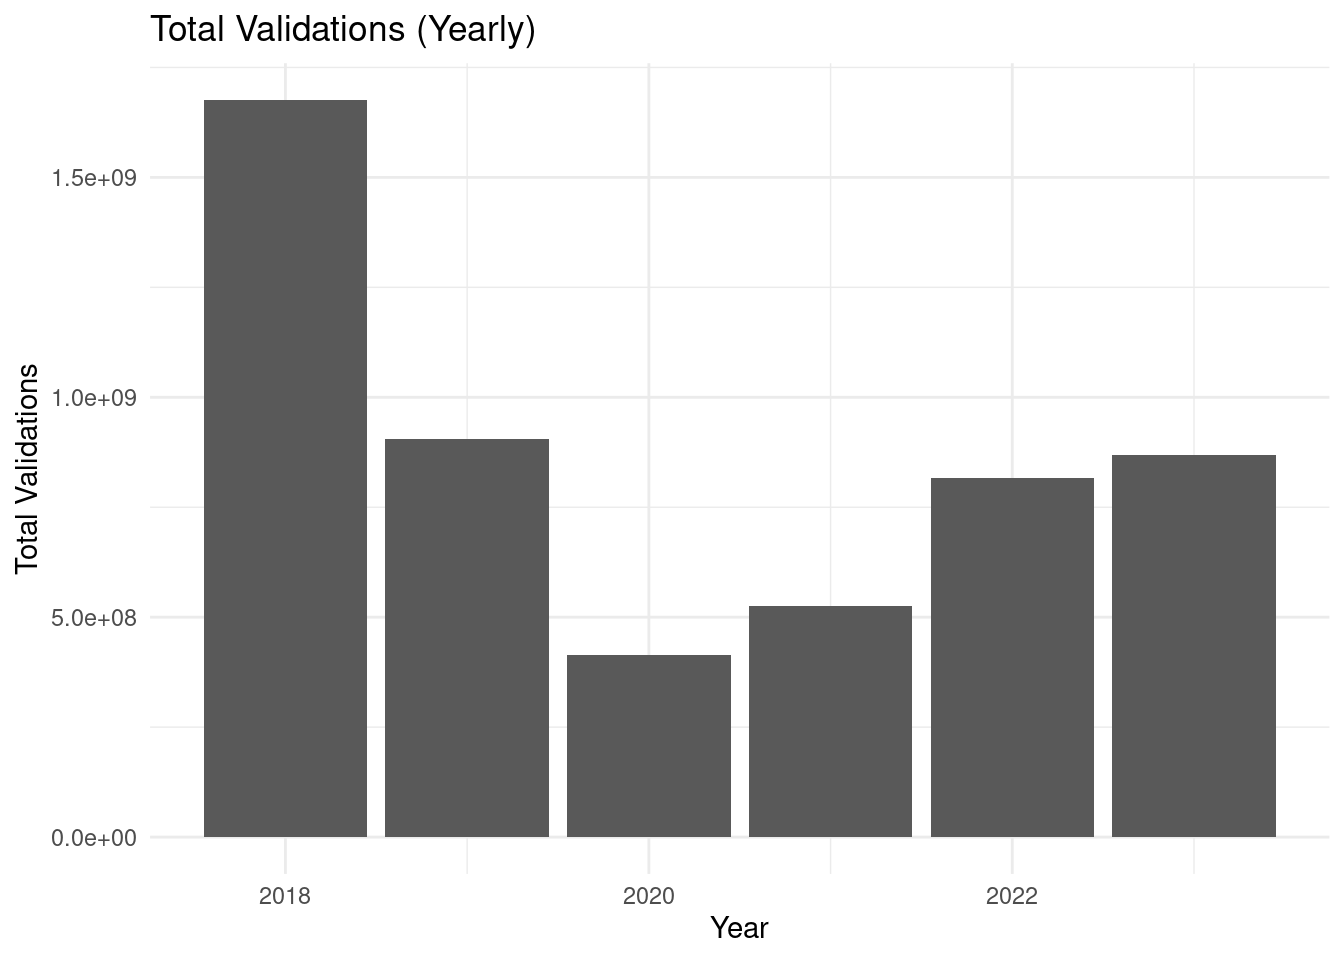

In [ ]:
yearly_sum <- combined_nb_vald |>
    mutate(year = year(jour)) |>
    group_by(year) |>
    summarize(total_validations = sum(nb_vald, na.rm = TRUE))

ggplot(yearly_sum, aes(x = year, y = total_validations)) +
    geom_col() +
    labs(title = "Total Validations (Yearly)", x = "Year", y = "Total Validations") +
    theme_minimal()

-   **Peak Ridership (2018-2019)**: The highest total validations occurred in 2018 and 2019, reflecting the high use of public transportation prior to the COVID-19 pandemic.
-   **Pandemic Impact (2020)**: A significant decrease in validations is seen in 2020, likely due to lockdowns, remote work, and reduced mobility during the pandemic.
-   **Partial Recovery (2021-2022)**: Ridership shows a gradual recovery in 2021 and 2022 as restrictions are eased.
-   **2023 Data Restriction**: The relatively lower total validations in 2023 are due to the lack of second semester data.

This visualization highlights the long-term impact of external events, such as a pandemic, on public transport ridership.

## Monthly Total Validations

This bar chart shows the total number of public transportation validations for each month from 2018 to 2023, providing a more detailed view of ridership trends than the annual summary.

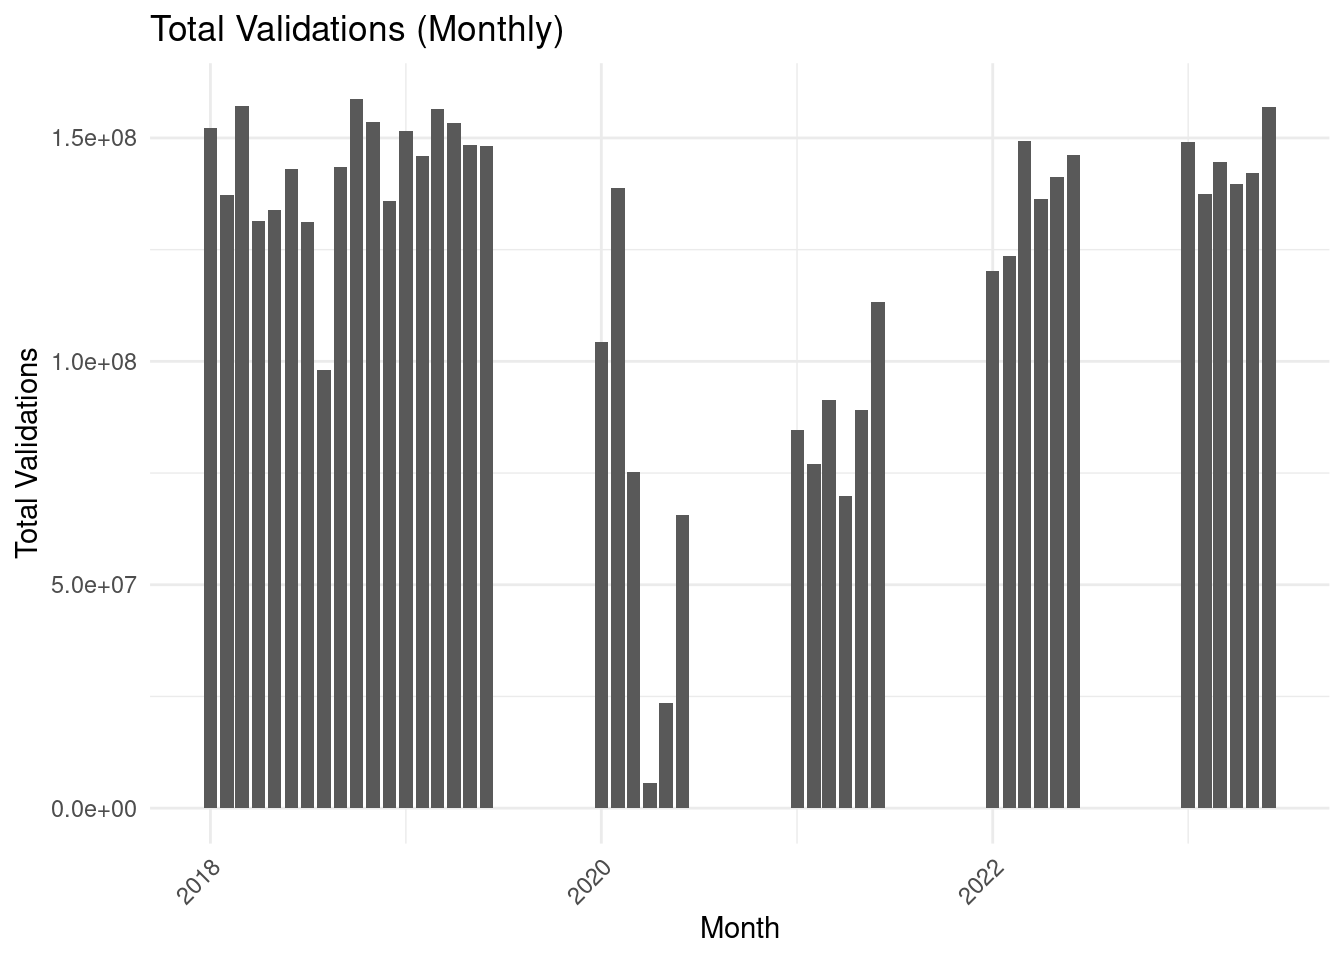

In [ ]:
monthly_sum <- combined_nb_vald |>
    mutate(month = floor_date(jour, "month")) |>
    group_by(month) |>
    summarize(total_validations = sum(nb_vald, na.rm = TRUE))

ggplot(monthly_sum, aes(x = month, y = total_validations)) +
    geom_col() +
    labs(title = "Total Validations (Monthly)", x = "Month", y = "Total Validations") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

-   **Regular Seasonal Patterns (2018-2019)**: Validations show consistent monthly patterns, reflecting seasonal fluctuations in public transportation usage.
-   **Pandemic Disruption (2020)**: A dramatic drop in monthly validations is observed beginning in early 2020, coinciding with the onset of the COVID-19 pandemic.
-   **Recovery in Later Years (2021-2022)**: Monthly validations show a gradual recovery as pandemic-related restrictions ease. However, they remain below pre-pandemic levels in some months.
-   **Incomplete Data (2023)**: Data for 2023 include only the first half of the year, as data for the second half of the year is not available at the time of analysis.

This graph highlights the detailed temporal impact of external events, such as the pandemic, on public transport usage patterns at a monthly resolution.

## Weekday Trend

This bar chart illustrates the average number of public transport validations for each day of the week across all years in the dataset. The visualization provides insight into how ridership varies on different days of the week.

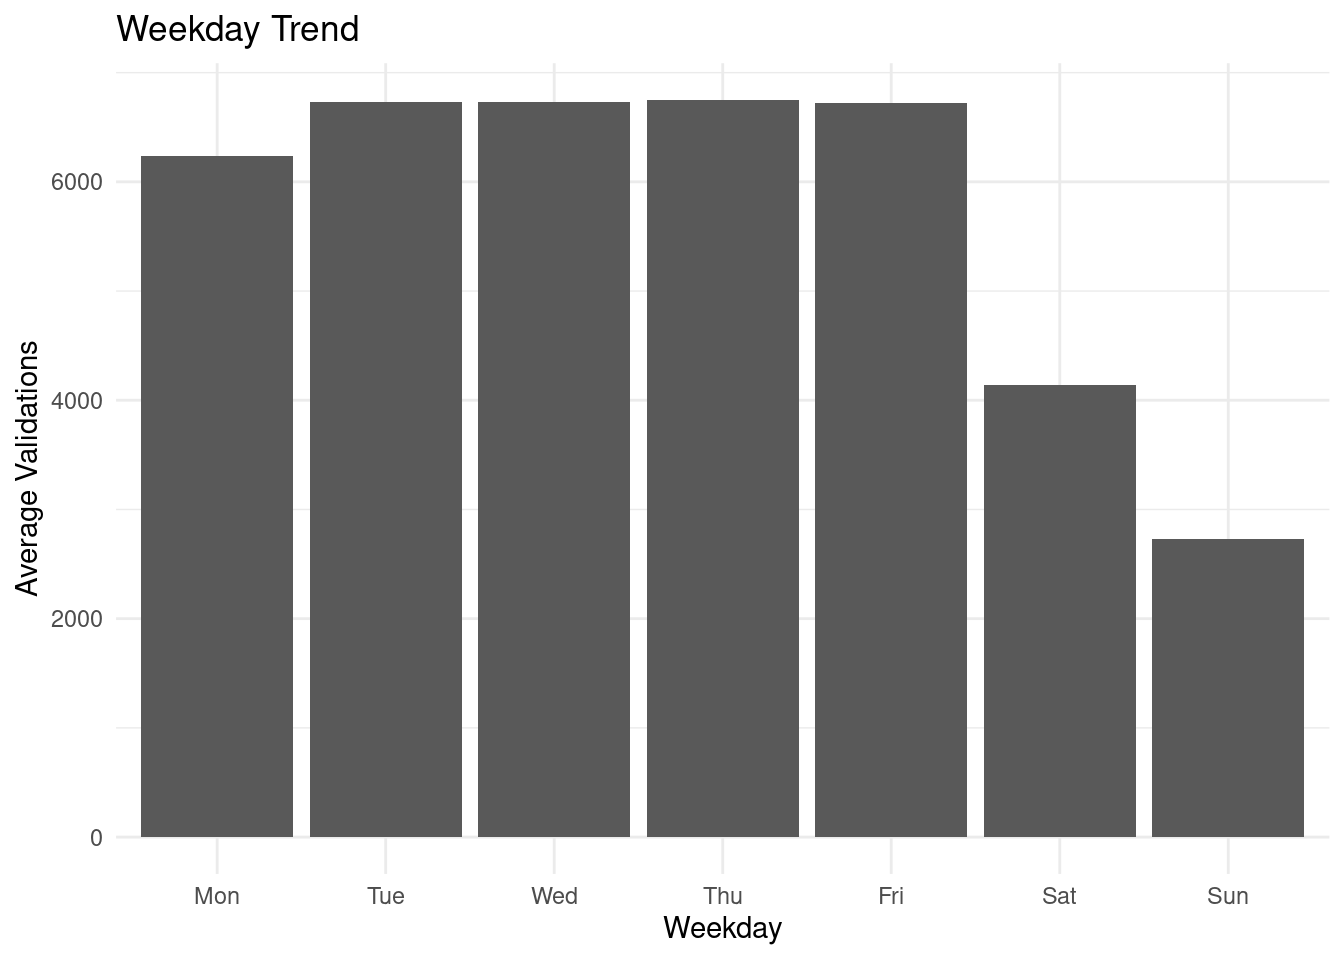

In [ ]:
weekday_trend <- combined_nb_vald |>
    mutate(weekday = wday(jour, label = TRUE, week_start = 1)) |>
    group_by(weekday) |>
    summarize(mean_vald = mean(nb_vald, na.rm = TRUE))

ggplot(weekday_trend, aes(x = weekday, y = mean_vald)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(title = "Weekday Trend", x = "Weekday", y = "Average Validations") +
    theme_minimal()

-   **Peak Usage on Weekdays**: Monday through Friday have consistently high average validations, indicating regular use of public transportation during the workday.
-   **Lower Usage on Weekends**: A significant drop is observed on Saturdays and Sundays, reflecting reduced commuting activity and leisure-oriented travel patterns.

This trend highlights the strong influence of the workweek schedule on public transport use.

## Comparison of two periods

This line graph compares the average number of transport trips over two selected 28-day periods, providing insight into temporal differences in transport ridership.

In [ ]:
input <- list()
input$start_date1 <- "2020-01-01"
input$start_date2 <- "2022-01-01"
input$period_days <- 28

comparison_data <- function() {
    days <- as.integer(input$period_days)
    period1 <- seq.Date(as.Date(input$start_date1), as.Date(input$start_date1) + days - 1, by = "day")
    period2 <- seq.Date(as.Date(input$start_date2), as.Date(input$start_date2) + days - 1, by = "day")

    period1_data <- combined_nb_vald |>
        filter(jour %in% period1) |>
        mutate(
            period = "Period 1",
            relative_day = as.numeric(jour - min(jour)) + 1
        )
    period2_data <- combined_nb_vald |>
        filter(jour %in% period2) |>
        mutate(
            period = "Period 2",
            relative_day = as.numeric(jour - min(jour)) + 1
        )

    return(bind_rows(period1_data, period2_data))
}

comparison_data <- comparison_data()

ℹ Please use `linewidth` instead.

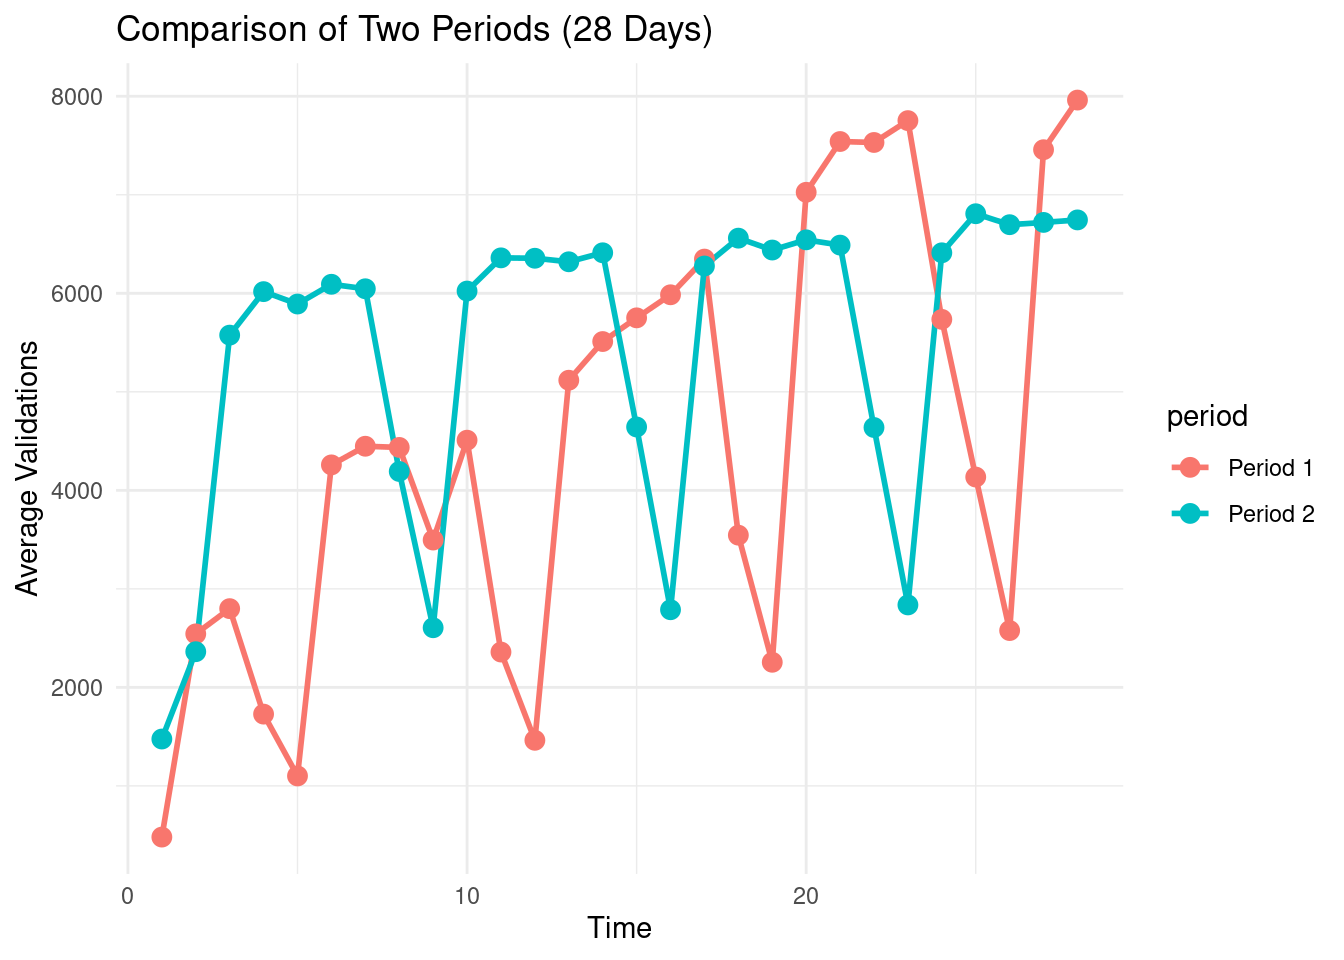

In [ ]:
daily_trend <- comparison_data |>
    group_by(relative_day, period, original_date = jour) |>
    summarize(avg_vald = mean(nb_vald, na.rm = TRUE), .groups = "drop")

ggplot(daily_trend, aes(x = relative_day, y = avg_vald, color = period, group = period)) +
    geom_line(size = 1) +
    geom_point(size = 3) +
    labs(
        title = paste("Comparison of Two Periods (", input$period_days, " Days)", sep = ""),
        x = "Time",
        y = "Average Validations"
    ) +
    theme_minimal()

-   **Distinct Patterns**: Period 1 (January 2020) and Period 2 (January 2022) show different trends, reflecting possible changes in travel behavior over time.
-   **Higher Activity in Period 2**: Period 2 consistently shows higher average validations, suggesting increased ridership recovery in 2022.
-   **Weekday Peaks**: Both periods show periodic peaks corresponding to weekdays, followed by declines on weekends, consistent with commuter trends.

This comparison highlights the usefulness of analyzing ridership trends over time to identify shifts in transport usage during and after the pandemic.

## Weekday Comparison of Two Periods

This bar chart visualizes the average daily boardings for each weekday over two different 28-day periods, providing a detailed comparison of weekday ridership patterns.

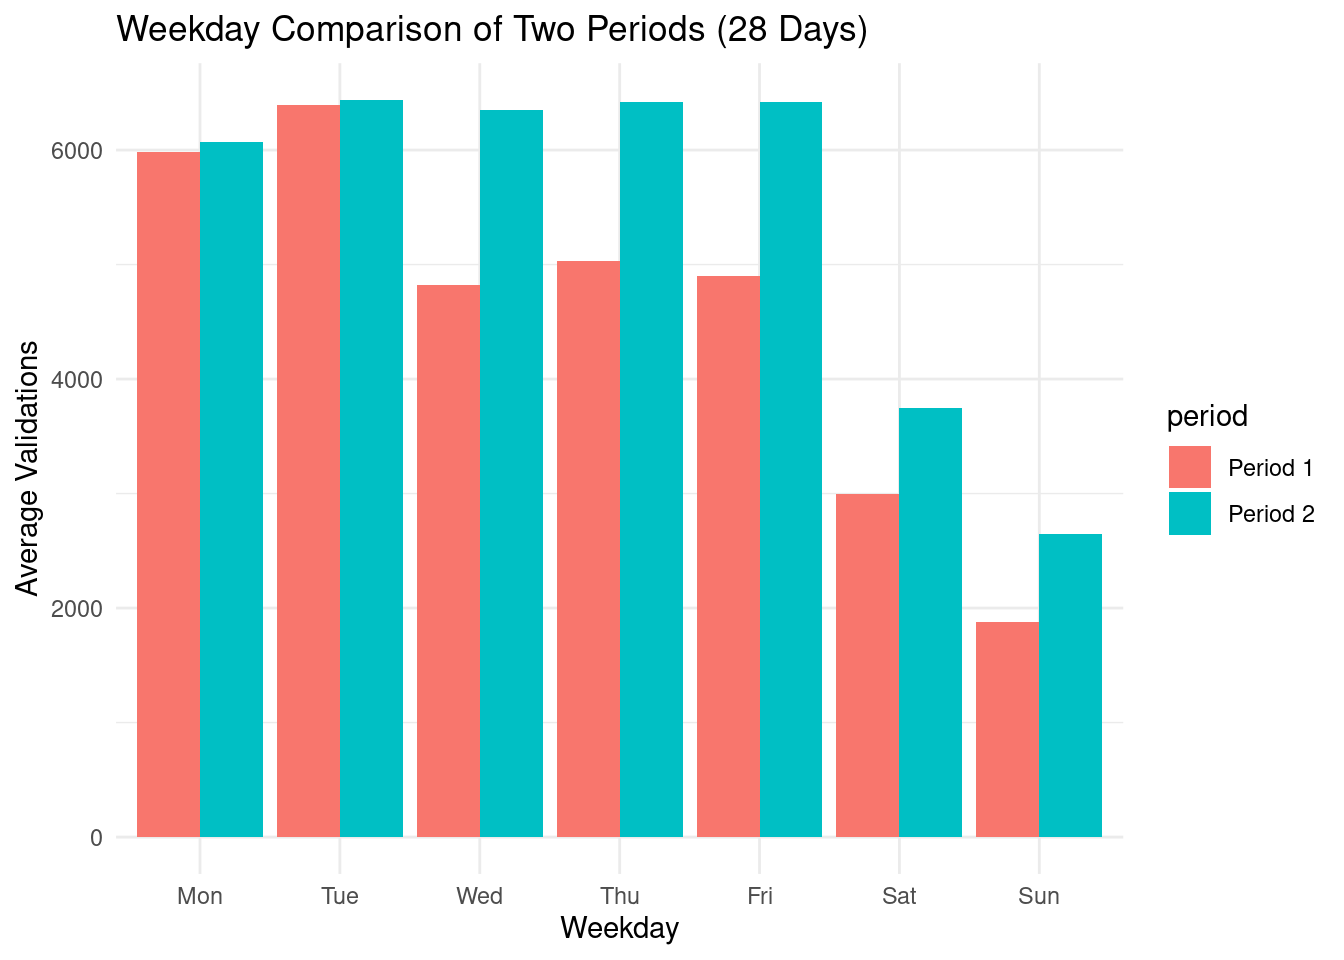

In [ ]:
weekday_trend <- comparison_data |>
    group_by(weekday = wday(jour, label = TRUE, week_start = 1), period) |>
    summarize(avg_vald = mean(nb_vald, na.rm = TRUE), .groups = "drop")

ggplot(weekday_trend, aes(x = weekday, y = avg_vald, fill = period)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(
        title = paste("Weekday Comparison of Two Periods (", input$period_days, " Days)", sep = ""),
        x = "Weekday",
        y = "Average Validations"
    ) +
    theme_minimal()

-   **Higher Validations in Period 2**: Across all weekdays, Period 2 (January 2022) has significantly higher average validations than Period 1 (January 2020), reinforcing the ridership recovery observations.
-   **Consistent Weekday Peaks**: Both periods show a clear weekday trend, with validations peaking Monday through Friday and declining on weekends.
-   **Saturday Variance**: The difference in validations between the two periods is less pronounced on Saturdays, possibly reflecting similar levels of leisure activity during both periods.

This graph underscores the importance of weekday trends in analyzing public transport use and highlights shifts in commuter behavior between the two periods.

## Spatial Distribution of Station Validations

The map shows the geographic distribution of public transport stations, with circle markers scaled according to the total number of validations recorded at each station.

In [ ]:
input <- list()
input$year <- 2023
input$station <- "NOISY-CHAMPS"
input$min_vald <- 1600000

selected_station_ids <- combined_nb_vald |>
    filter(libelle_arret == input$station) |>
    distinct(id_refa_lda) |>
    pull(id_refa_lda)

yearly_validations <- combined_nb_vald |>
    filter(year(jour) == as.numeric(input$year)) |>
    group_by(libelle_arret, id_refa_lda) |>
    summarize(total_validations = sum(nb_vald, na.rm = TRUE), .groups = "drop") |>
    filter(total_validations >= input$min_vald)

vald_spatial_joined <- zones_spatial |>
    left_join(yearly_validations, by = c("id_refa_lda" = "id_refa_lda")) |>
    mutate(
        scaled_size = ifelse(is.na(total_validations), 5, total_validations / max(total_validations, na.rm = TRUE) * 20)
    )

Warning in left_join(zones_spatial, yearly_validations, by = c(id_refa_lda = "id_refa_lda")): Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 551 of `x` matches multiple rows in `y`.
ℹ Row 101 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.

Warning in validateCoords(lng, lat, funcName): Data contains 1 rows with either
missing or invalid lat/lon values and will be ignored

-   **Densely Populated Areas**: Stations in central regions have denser clusters, indicating higher ridership in urban centers.
-   **Validation Scaling**: Larger circles represent stations with higher validation counts, indicating key activity centers within the network.
-   **Highlighted Station**: The selected station (`"NOISY-CHAMPS"`) is uniquely identified, providing a focus for further analysis and comparison.

This spatial representation provides an intuitive view of network usage patterns, helping to identify areas of high demand and prioritize resource allocation.

## Hourly Validation Profiles for “NOISY-CHAMPS” (2023)

The graph shows the hourly distribution of validations at the `"NOISY-CHAMPS"` station for the year `2023`. Validation percentages are grouped by day type, such as weekdays, weekends, and holidays, to reveal temporal patterns in ridership.

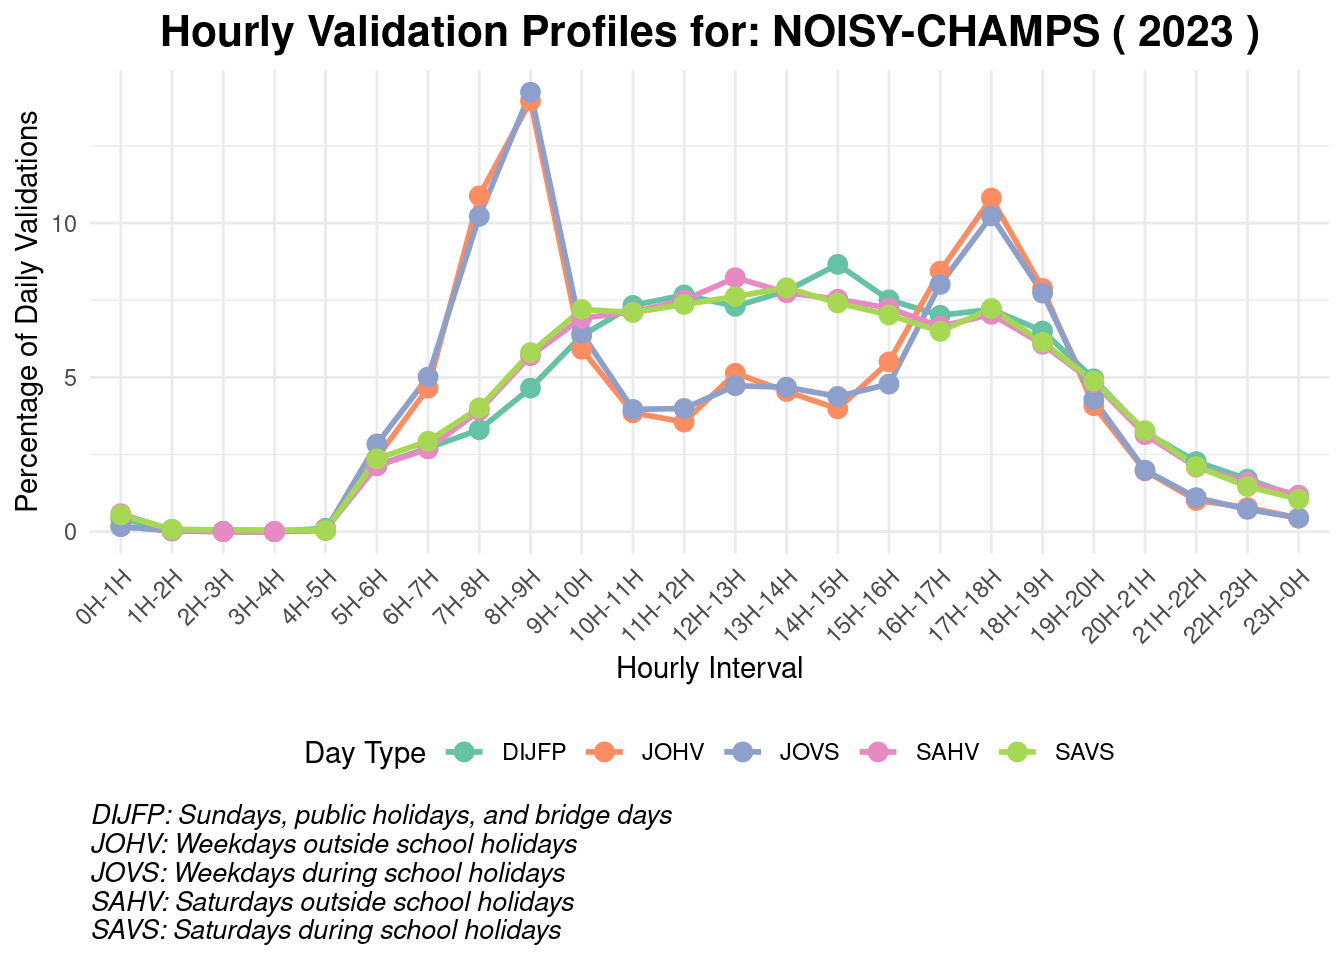

In [ ]:
input <- list()
input$station <- "NOISY-CHAMPS"
input$year <- 2023

hourly_levels <- c(
    "0H-1H", "1H-2H", "2H-3H", "3H-4H", "4H-5H", "5H-6H",
    "6H-7H", "7H-8H", "8H-9H", "9H-10H", "10H-11H", "11H-12H",
    "12H-13H", "13H-14H", "14H-15H", "15H-16H", "16H-17H",
    "17H-18H", "18H-19H", "19H-20H", "20H-21H", "21H-22H",
    "22H-23H", "23H-0H"
)
station_profil <- combined_profil |>
    filter(as.numeric(jour) == as.numeric(input$year)) |>
    filter(id_refa_lda %in% selected_station_ids) |>
    mutate(trnc_horr_60 = factor(trnc_horr_60, levels = hourly_levels, ordered = TRUE))
if (nrow(station_profil) == 0) {
    return(NULL)
}

day_type_descriptions <- paste(
    "DIJFP: Sundays, public holidays, and bridge days",
    "JOHV: Weekdays outside school holidays",
    "JOVS: Weekdays during school holidays",
    "SAHV: Saturdays outside school holidays",
    "SAVS: Saturdays during school holidays",
    sep = "\n"
)

ggplot(station_profil, aes(x = trnc_horr_60, y = pourc_validations, group = cat_jour, color = cat_jour)) +
    geom_line(size = 1) +
    geom_point(size = 3) +
    scale_color_brewer(palette = "Set2") +
    labs(
        title = paste("Hourly Validation Profiles for:", input$station, "(", input$year, ")", sep = " "),
        caption = day_type_descriptions,
        x = "Hourly Interval",
        y = "Percentage of Daily Validations",
        color = "Day Type"
    ) +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "bottom",
        plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
        plot.caption = element_text(size = 10, hjust = 0, face = "italic")
    )

-   **Morning Peak**: Validation percentages peak sharply between 7 and 9 AM., especially on non-school vacation weekdays (`JOHV`), indicating heavy commuter traffic.
-   **Evening Peak**: A secondary peak occurs from 5 PM to 7 PM, reflecting the evening rush hour.
-   **Day Type Differences**: Weekend and holiday profiles (e.g. `DIJFP`, `SAVS`) show a more spread out activity pattern with less pronounced peaks compared to weekdays.
-   **Off-Peak Hours**: Minimal activity is observed during the late night and early morning hours (midnight to 5 AM), consistent across all day types.

This visualization highlights commuter behavior and the influence of day types on ridership patterns, providing valuable insight for resource planning and scheduling.

## Total Validations Forecast for 2023 S2

The graph shows the projected total validations for the second half of 2023 based on historical ridership data using time series modeling.

In [ ]:
input <- list()
input$forecast_days <- 184

forecast_result <- function() {
    historical_data <- combined_nb_vald |>
        group_by(jour) |>
        summarise(total_validations = sum(nb_vald, na.rm = TRUE), .groups = "drop")

    ts_data <- ts(historical_data$total_validations, frequency = 365, start = c(2018, 1))
    forecast_result <- stlf(ts_data, h = input$forecast_days)

    return(forecast_result)
}

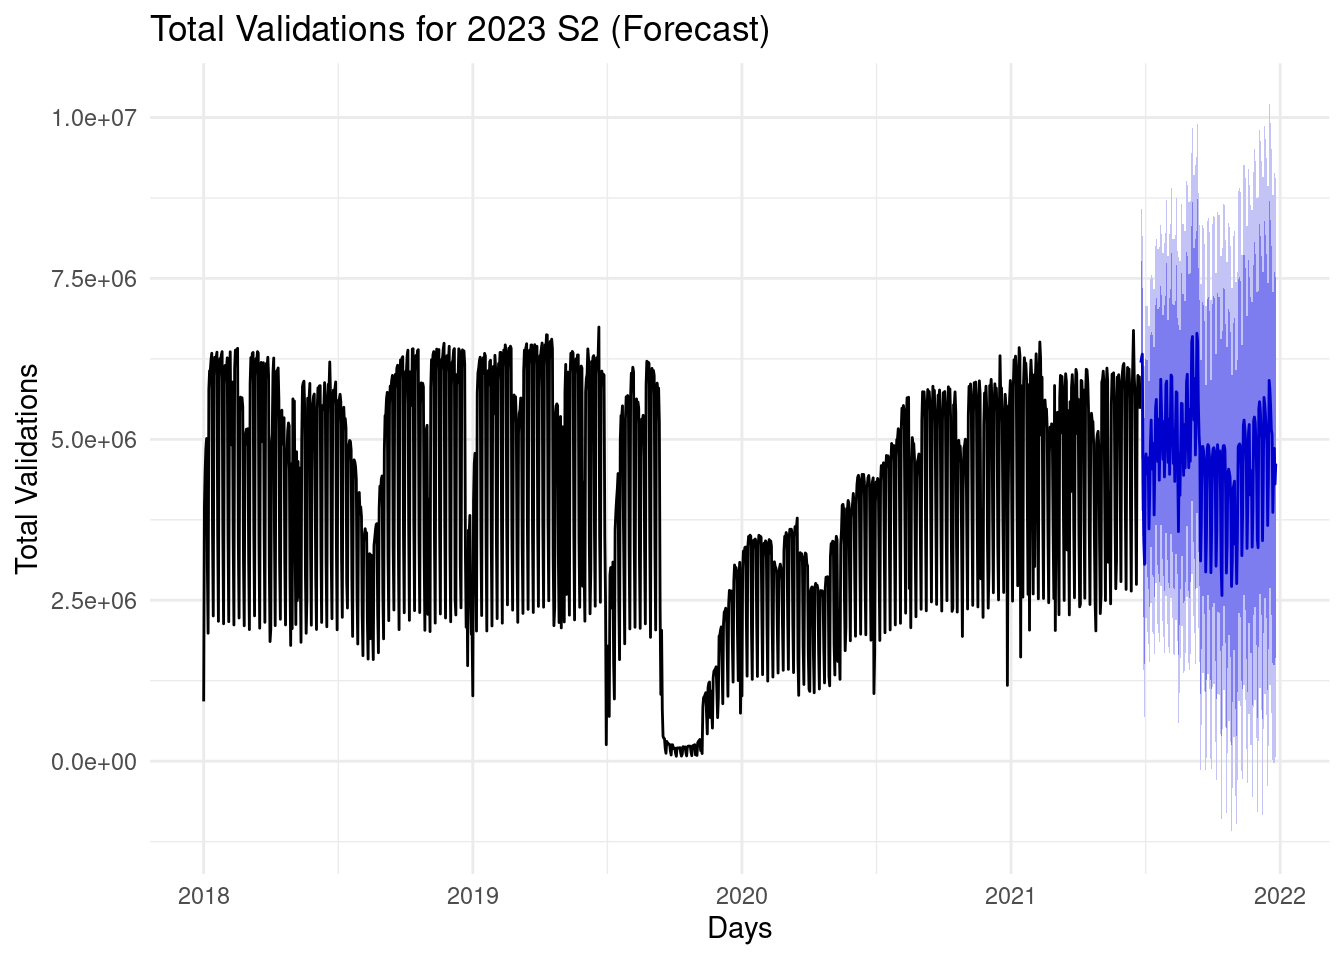

In [ ]:
forecast_result <- forecast_result()

autoplot(forecast_result) +
    labs(
        title = "Total Validations for 2023 S2 (Forecast)",
        x = "Days",
        y = "Total Validations"
    ) +
    theme_minimal()

-   **Historical Data Overview**: The black line represents the total daily validations from 2018 to 2023 S1, showing seasonal and periodic trends.
-   **Forecast Data**: The blue shaded region represents the forecast for 2023 S2, including a confidence interval.
    -   The darker blue line indicates the predicted central trend, suggesting an overall increase in ridership.
    -   The lighter blue bands indicate uncertainty and extend further into the future, reflecting increased variability.
-   **Seasonal Patterns**: The forecast captures and projects the seasonal trends seen in the historical data, adding to the reliability of the model.

This forecast is critical for planning resources, forecasting demand, and effectively managing operations in 2023 and beyond.

# Conclusion

## Challenges and Limitations

Several challenges emerged throughout the project. The quality of the dataset was an issue as inconsistencies required additional pre-processing such as filtering of outliers and standardization of columns. In addition, the COVID-19 pandemic introduced irregularities in ridership patterns, particularly in 2020 and 2021, which made trend analysis and forecasting difficult. These disruptions made it difficult to effectively apply standard time series models. In addition, the integration of spatial data with multi-year ridership data required careful optimization to ensure deployment efficiency and user interactivity.

## Future work

This analysis provides a foundation for future enhancements. Advanced predictive models, such as machine learning techniques, could be explored to improve prediction accuracy and account for non-linear trends. In addition, by reducing the dataset to a subset, not all possible analyses were performed. Future work could focus on the different types of transit and their tickets, the `CATEGORY_TITRE` could be used to analyze the impact of different ticket types on ridership. In addition, external factors such as weather or major events such as the Olympics could be incorporated to provide a more comprehensive analysis of ridership patterns.

## Summary

This project analyzed public transport ridership in the IDF region from 2018 to 2023, providing valuable insights into patterns and trends. A robust data pipeline was developed to clean, integrate, and prepare both ridership and spatial datasets. Analysis revealed yearly, monthly, and weekday trends, demonstrating the impact of COVID-19 on ridership and subsequent recovery. The project also included interactive and static visualizations that highlighted spatial and temporal variations in ridership. A forecast for the second half of 2023 was generated. In addition, an automated workflow for deployment to Shinyapps.io was developed, allowing for seamless updates and maintenance of the application.

The deployed application can be found at: [DSViz: IDF Ridership Analysis](https://luckerma.shinyapps.io/DSViz_Project/)

# References